In [53]:
#| default_exp activations

In [54]:

#|export
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *


In [55]:
import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torcheval.metrics import MulticlassAccuracy
from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [56]:

#|export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [57]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

In [58]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

In [59]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn


accuracy,loss,epoch,train
0.161,2.295,0,train
0.359,1.994,0,eval
0.449,1.504,1,train
0.720,0.923,1,eval
0.704,0.784,2,train
0.743,0.756,2,eval


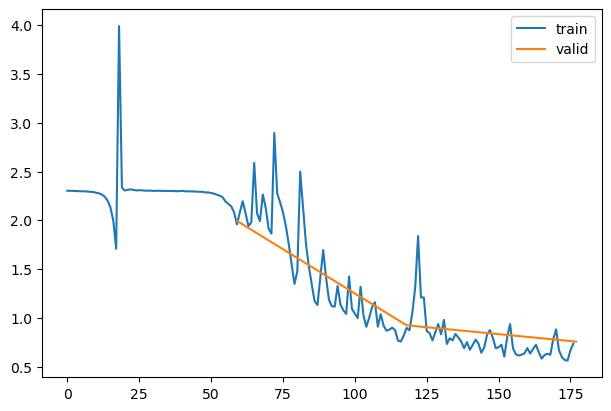

In [60]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()), epochs=3)

### Manually maintained metrics

In [61]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds [i].append(to_cpu(x).std ())
        return x
    
    def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.161,2.295,0,train
0.359,1.994,0,eval


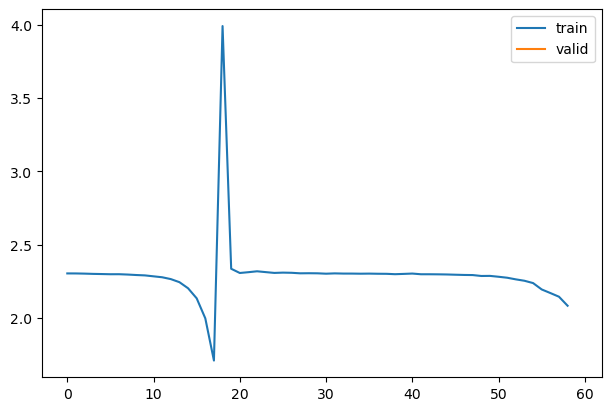

In [62]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)


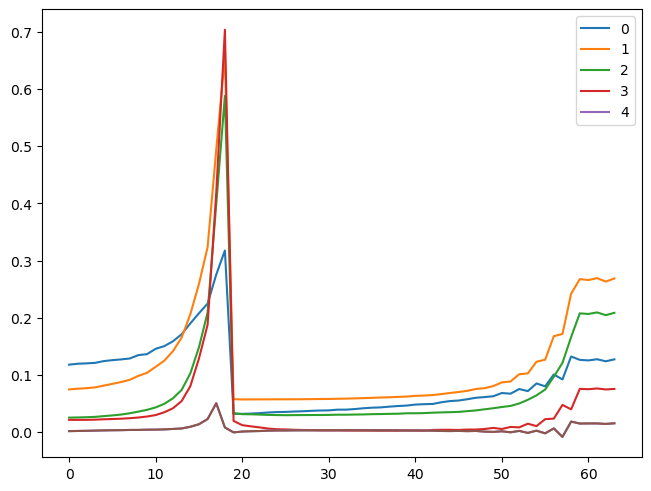

In [63]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

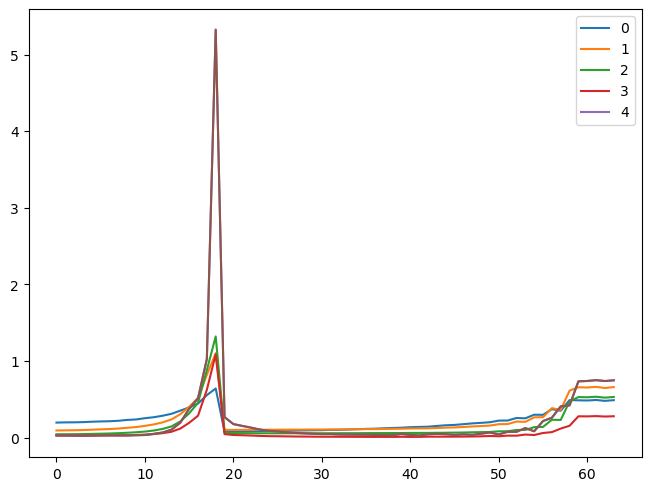

In [64]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

> Here we can see most of the nodes are dead. Between batches 15 and 20 there was an event that caused our nodes to be highly spread out. Seen by the spike in standard deviation.  Ideally we should see the mean graph stay around 0, with the standard devations around 1.  This would mean our nodes are grouped around 0 mostly between -1 and 1.

### Pytorch Hooks

Pytorch has the ability to register a hook to a layer.  This allows us to execute code when the layer activates during the forward or backward pass.

In [65]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [66]:
# Our hook method, it simply needs to accept a module, input and output. 
# The value for i here comes from the partial call below to give us the layer number 
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds [i].append(to_cpu(outp).std())


In [67]:
# Registering hooks 
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.161,2.295,0,train
0.359,1.994,0,eval


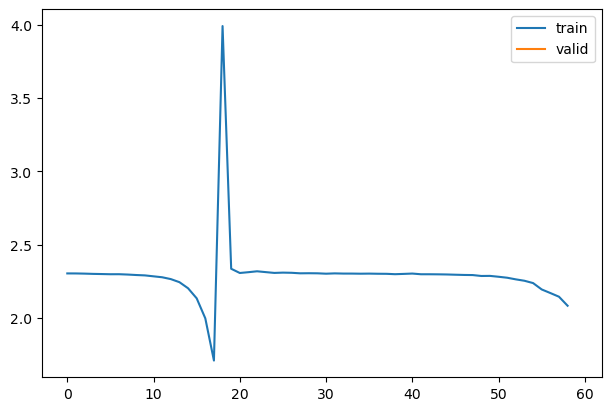

In [68]:
fit(model)

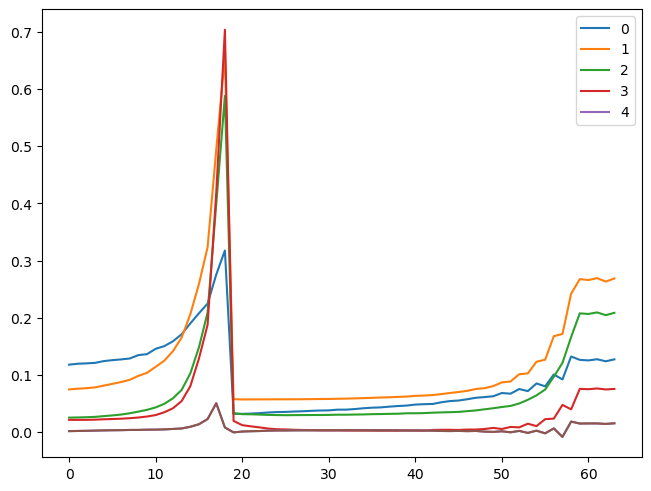

In [69]:
# Now we can retrieve the means that were appended to by our hook function.
for o in act_means: plt.plot(o)
plt.legend(range(5));


In [70]:
#| export
class Hook():
    def __init__(self, module, func): self.hook = module.register_forward_hook(partial(func, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [81]:
# Now I need to update the append_stats function since the first argument is changing. 
# Rather than a simple counter we are passed the Hook class that registered the hook with the module.
# Now we can use that class to maintain our stats
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())


accuracy,loss,epoch,train
0.161,2.295,0,train
0.359,1.994,0,eval


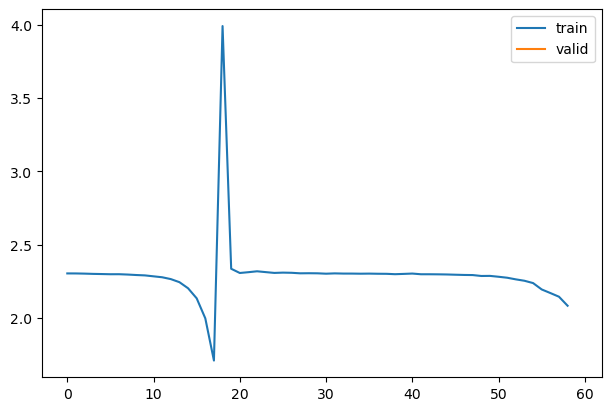

In [82]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hooks = [Hook(l, append_stats) for l in model[:5].children()]
learn = fit(model)
hooks


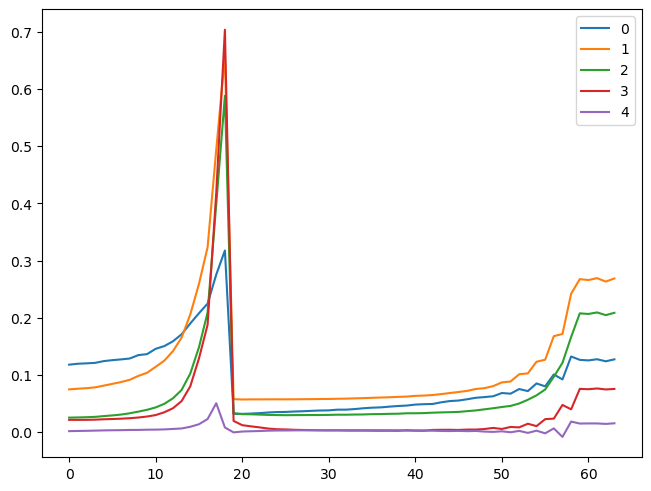

In [83]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));


In [84]:
# Now I dont want to manage the individual hooks independently so time for a wrapper.
# This is a context manager that returns itself and registers our hooks. 
# The class will extend list to allow us to treat it as a list that stores the hooks
class Hooks(list):
    def __init__(self, modules, function): super().__init__([Hook(m, function) for m in modules])
    def __enter__(self, *args): return self # Returns self here so we can use `with as` to get our list of hooks
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __defitem__(self, i): 
        self.remove()
        super().__delitem__(i)
    def remove(self): 
        for h in self: h.remove()

accuracy,loss,epoch,train
0.161,2.295,0,train
0.359,1.994,0,eval


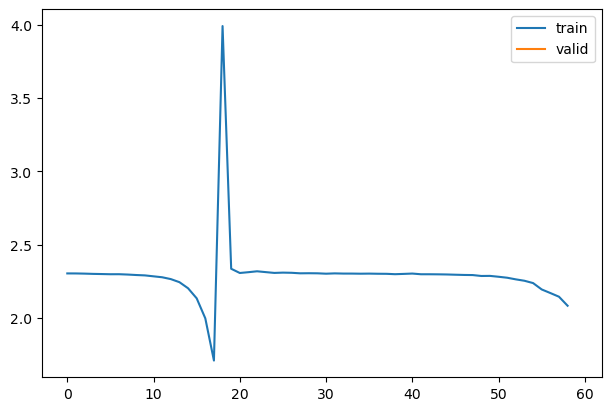

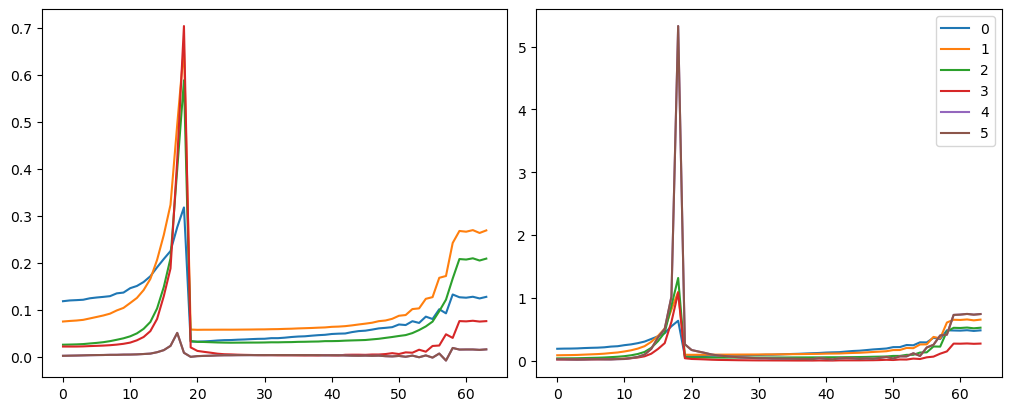

In [85]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

with Hooks(model, append_stats) as hooks:
    fit(model)
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks: # hooks is our hooks class that acts as a list of individual hooks
        for i in 0,1: axs[i].plot(h.stats[i])
    plt.legend(range(6));


> This hooks logic can be encapsulated in a callback to simplify the running process.


In [ ]:

#| export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        if self.mods: mods=self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)


In [ ]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.161,2.295,0,train
0.359,1.994,0,eval


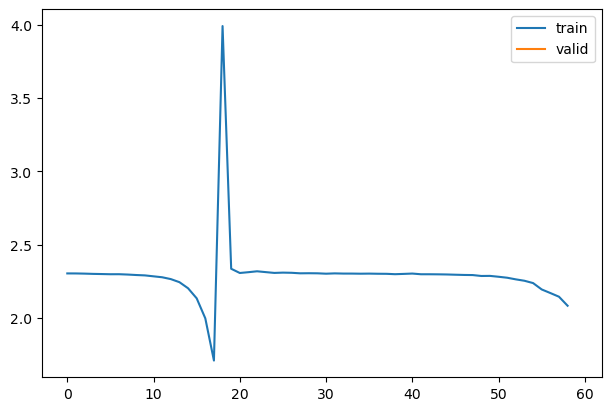

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);


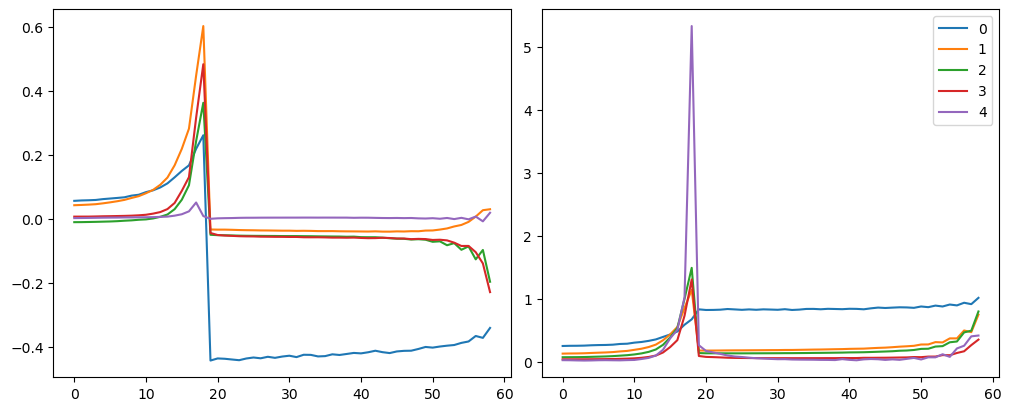

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));


### Histograms

This is a way of visiualizing the activations to see how our model is training.  It shows the distrobution of weight values in color coordinated bars over time.  If the histogram is especially heavy at the bottom it is probably mostly dead. Spikes and collapes in the histogram also indicates a poorly training model.

> New append stats method that accumulates the histogram data as well as our other metrics

In [86]:
#| export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10)) 


accuracy,loss,epoch,train
0.161,2.295,0,train
0.359,1.994,0,eval


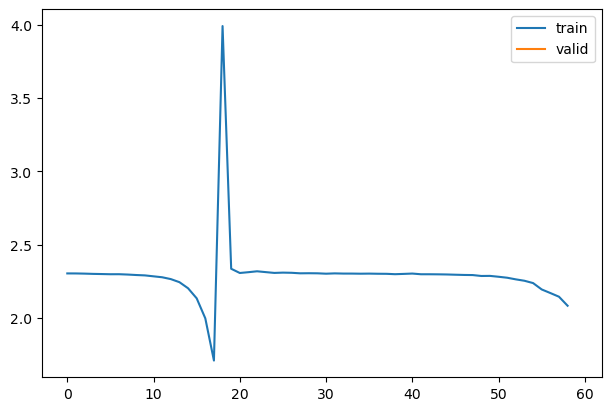

In [87]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);


In [88]:
#| export
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p() # log here helps distribute the data in a useful visiual manner


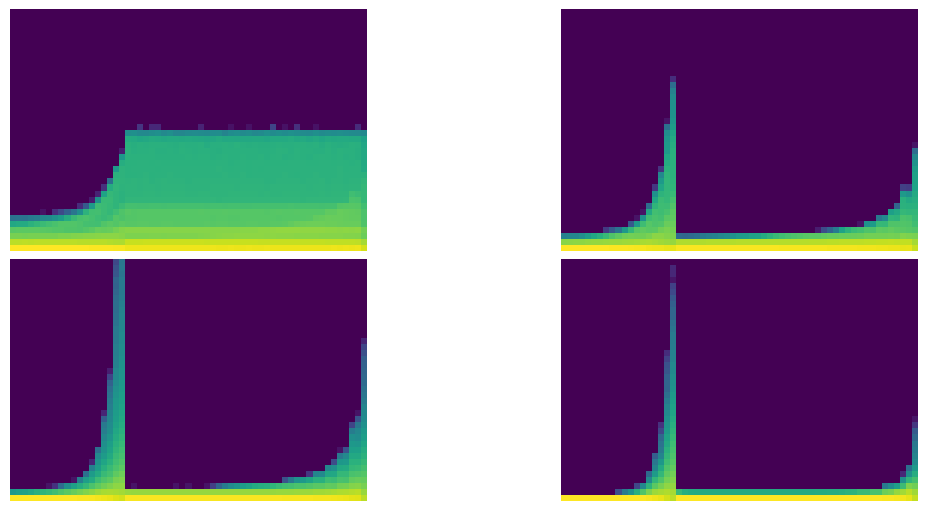

In [89]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')


> This get_min method shows the percentage of weights that fall into the lowest bar on the histogram. These would be our very dead nodes.

In [90]:
#| export
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)


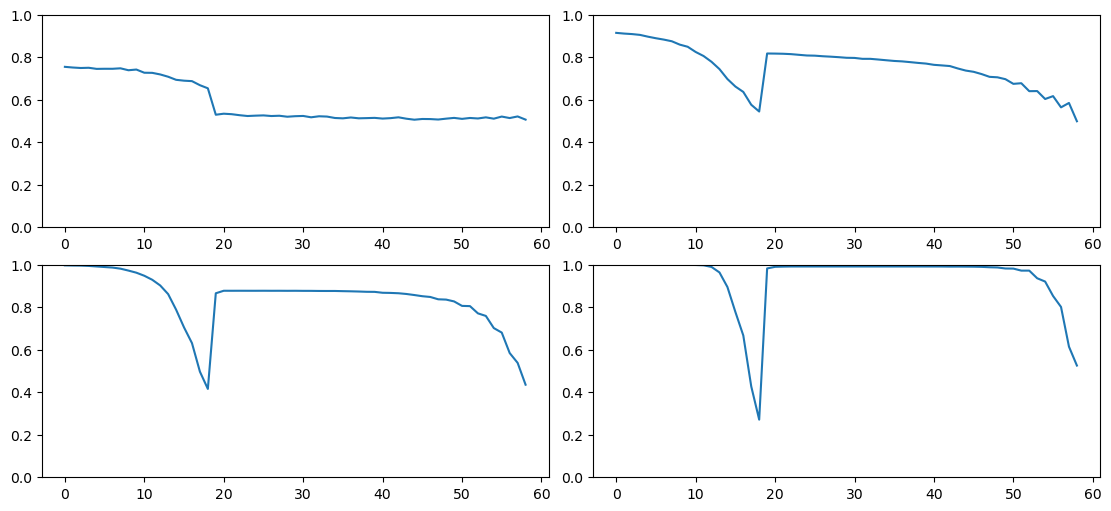

In [91]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)


> Now to extend our hooks callback to contain some of our graphing logic as well

In [92]:
#|export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)
    def color_dim(self, figsize=(11,5)):
        fig,axs = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axs.flat, self):
            show_image(get_hist(h), ax, origin='lower')
    
    def dead_chart(self, figsize=(11,5)):
        fig,axs = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axs.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)
            
    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

accuracy,loss,epoch,train
0.161,2.295,0,train
0.359,1.994,0,eval


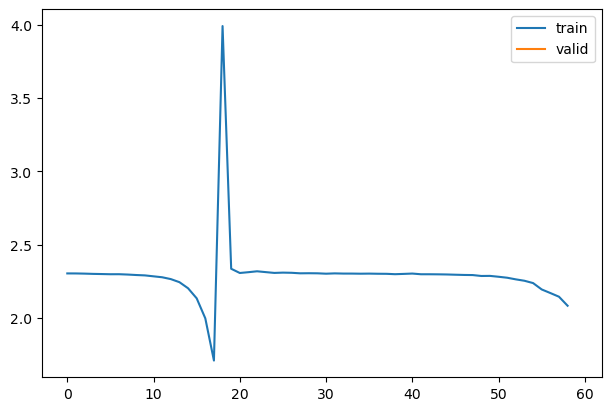

In [93]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);



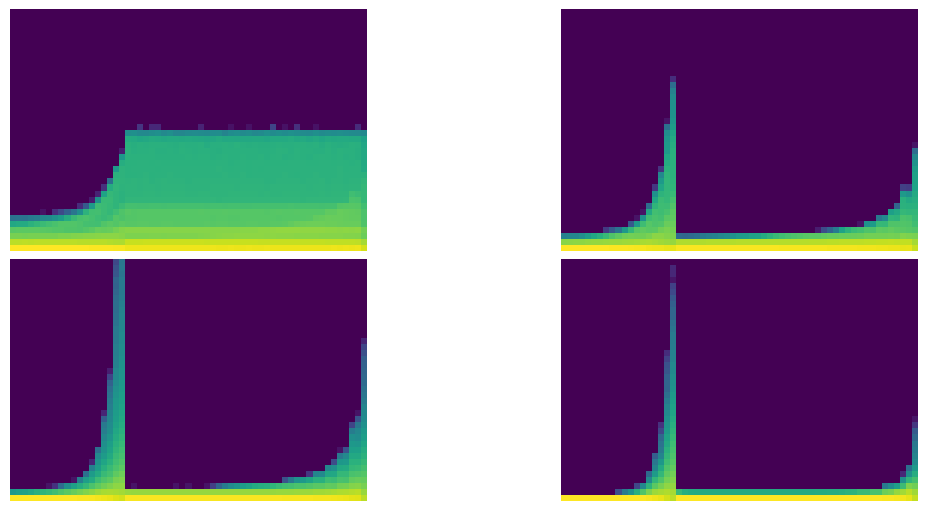

In [94]:
astats.color_dim()

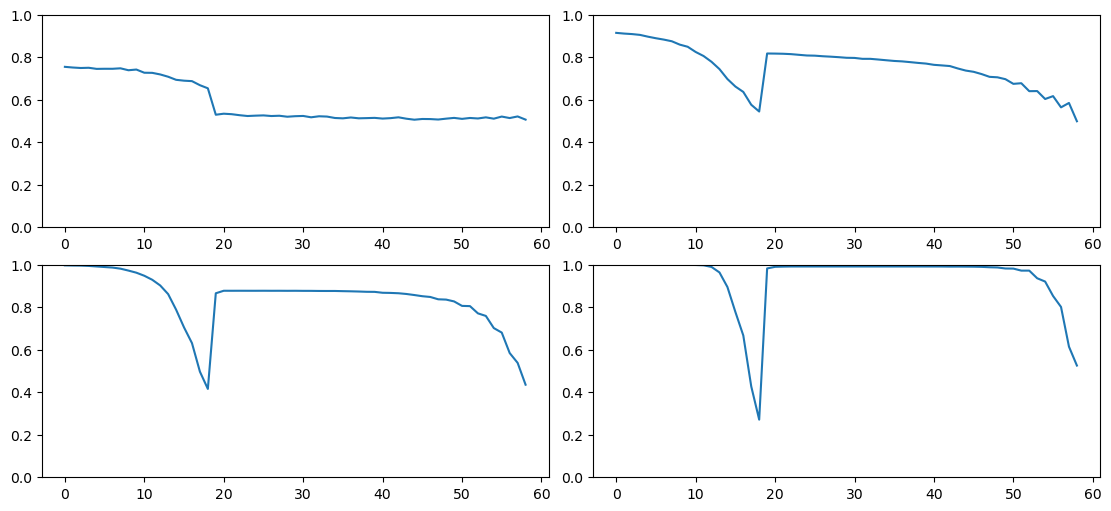

In [95]:
astats.dead_chart()

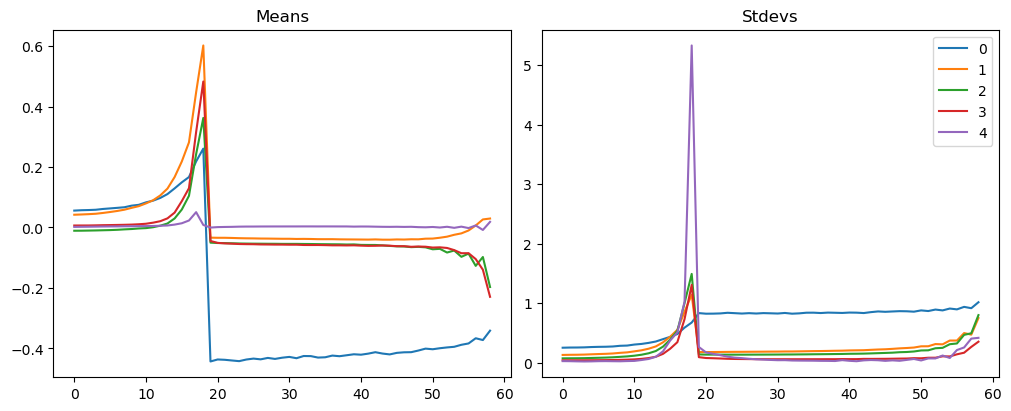

In [96]:
astats.plot_stats()


In [97]:
import nbdev; nbdev.nbdev_export()
